Below is a simple example of a job shop problem, in which each task is labeled by a pair of numbers (m, p) where m is the number of the machine the task must be processed on and p is the processing time of the task — the amount of time it requires. (The numbering of jobs and machines starts at 0.)

job 0 = [(0, 3), (1, 2), (2, 2)]

job 1 = [(0, 2), (2, 1), (1, 4)]

job 2 = [(1, 4), (2, 3)]

In the example, job 0 has three tasks. The first, (0, 3), must be processed on machine 0 in 3 units of time. The second, (1, 2), must be processed on machine 1 in 2 units of time, and so on. Altogether, there are eight tasks.


https://developers.google.com/optimization/scheduling/job_shop

In [1]:
import pandas as pd
import numpy as np
from docplex.cp.model import  CpoModel
import docplex.cp.utils_visu as visu


pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

import matplotlib.pyplot as plt
%matplotlib inline
#Change the plot size
from pylab import rcParams
rcParams['figure.figsize'] = 15, 3

In [2]:
job_0 = [(0, 3), (1, 2), (2, 2)]
job_1 = [(0, 2), (2, 1), (1, 4)]
job_2 = [(1, 4), (2, 3)]

jobs_data = pd.DataFrame([])
i=0
for j in [job_0,  job_1,  job_2  ]: 
    u = pd.DataFrame(j, columns = ['machine','duration'])
    u['job'] = i
    u['order'] = np.arange(0,len(u))
    jobs_data = pd.concat([jobs_data,u], axis = 0)
    i=i+1

jobs_data = jobs_data[['job','order', 'machine', 'duration']].reset_index(drop = True)
jobs_data

,job,order,machine,duration
0,0,0,0,3
1,0,1,1,2
2,0,2,2,2
3,1,0,0,2
4,1,1,2,1
5,1,2,1,4
6,2,0,1,4
7,2,1,2,3


In [3]:
horizon = jobs_data['duration'].sum()
horizon

21

In [20]:
mdl = CpoModel(name="JobScheduling")


DV=[]
for row in jobs_data.itertuples():
    #print(i)
    dv = mdl.interval_var(size  =  row.duration, name='Job%s_Machine%s'%(row.job, row.machine  ))# ,  , 
    DV.append(dv) 
jobs_data['DV'] = DV
jobs_data

,job,order,machine,duration,DV,endtime,DV_sol,DV_sol_start,DV_sol_end
0,0,0,0,3,Job0_Machine0 = intervalVar(size=3),endOf(Job0_Machine0),"Job0_Machine0: (start=2, end=5, size=3, length=3)",2,5
1,0,1,1,2,Job0_Machine1 = intervalVar(size=2),endOf(Job0_Machine1),"Job0_Machine1: (start=0, end=2, size=2, length=2)",0,2
2,0,2,2,2,Job0_Machine2 = intervalVar(size=2),endOf(Job0_Machine2),"Job0_Machine2: (start=1, end=3, size=2, length=2)",1,3
3,1,0,0,2,Job1_Machine0 = intervalVar(size=2),endOf(Job1_Machine0),"Job1_Machine0: (start=0, end=2, size=2, length=2)",0,2
4,1,1,2,1,Job1_Machine2 = intervalVar(size=1),endOf(Job1_Machine2),"Job1_Machine2: (start=0, end=1, size=1, length=1)",0,1
5,1,2,1,4,Job1_Machine1 = intervalVar(size=4),endOf(Job1_Machine1),"Job1_Machine1: (start=2, end=6, size=4, length=4)",2,6
6,2,0,1,4,Job2_Machine1 = intervalVar(size=4),endOf(Job2_Machine1),"Job2_Machine1: (start=6, end=10, size=4, length=4)",6,10
7,2,1,2,3,Job2_Machine2 = intervalVar(size=3),endOf(Job2_Machine2),"Job2_Machine2: (start=3, end=6, size=3, length=3)",3,6


mdl.add( mdl.end_before_start(DV[0], DV[1]) )
mdl.add( mdl.end_before_start(DV[0], DV[2]) )
mdl.add( mdl.end_before_start(DV[1], DV[2]) )


print("\nSolving model....")
msol = mdl.solve(TimeLimit=10)
print("done")

In [21]:
all_jobs = jobs_data['job'].unique()
all_machines = jobs_data['machine'].unique()


def extract_precedence(m):
    AllOrders = []
    for i in m.keys():
        for j in m.keys():
            if m[i]<m[j]:
                AllOrders.append([i,j])

    return AllOrders


for i in all_jobs:
    u= jobs_data[jobs_data['job']==i]
    m = dict(zip(u.index, u.order.values))
    precedence_list = extract_precedence(m)

    for j in precedence_list:
        print("The task ", jobs_data.loc[j[0]]['DV'] , '   should be before   ', jobs_data.loc[j[1]]['DV'])

        mdl.add( mdl.end_before_start(jobs_data.loc[j[0]]['DV'], jobs_data.loc[j[1]]['DV']) )
        #mdl.no_overlap([jobs_data.loc[j[0]]['DV'], jobs_data.loc[j[1]]['DV']])


The task  Job0_Machine0 = intervalVar(size=3)    should be before    Job0_Machine1 = intervalVar(size=2)
The task  Job0_Machine0 = intervalVar(size=3)    should be before    Job0_Machine2 = intervalVar(size=2)
The task  Job0_Machine1 = intervalVar(size=2)    should be before    Job0_Machine2 = intervalVar(size=2)
The task  Job1_Machine0 = intervalVar(size=2)    should be before    Job1_Machine2 = intervalVar(size=1)
The task  Job1_Machine0 = intervalVar(size=2)    should be before    Job1_Machine1 = intervalVar(size=4)
The task  Job1_Machine2 = intervalVar(size=1)    should be before    Job1_Machine1 = intervalVar(size=4)
The task  Job2_Machine1 = intervalVar(size=4)    should be before    Job2_Machine2 = intervalVar(size=3)


In [22]:
for i in all_machines:
    u= jobs_data[jobs_data['machine']==i]
    
    print(  [k.name for k in  u['DV'].values.tolist()], "  shouldn't overlap")
    mdl.add ( mdl.no_overlap(  u['DV'].values.tolist()))


['Job0_Machine0', 'Job1_Machine0']   shouldn't overlap
['Job0_Machine1', 'Job1_Machine1', 'Job2_Machine1']   shouldn't overlap
['Job0_Machine2', 'Job1_Machine2', 'Job2_Machine2']   shouldn't overlap


In [23]:
jobs_data.loc[:,'endtime']=jobs_data['DV'].apply(lambda x:mdl.end_of(x))
#jobs_data.loc[:,'starttime']=jobs_data['DV'].apply(lambda x:mdl.start_of(x))
jobs_data 

,job,order,machine,duration,DV,endtime,DV_sol,DV_sol_start,DV_sol_end
0,0,0,0,3,Job0_Machine0 = intervalVar(size=3),endOf(Job0_Machine0),"Job0_Machine0: (start=2, end=5, size=3, length=3)",2,5
1,0,1,1,2,Job0_Machine1 = intervalVar(size=2),endOf(Job0_Machine1),"Job0_Machine1: (start=0, end=2, size=2, length=2)",0,2
2,0,2,2,2,Job0_Machine2 = intervalVar(size=2),endOf(Job0_Machine2),"Job0_Machine2: (start=1, end=3, size=2, length=2)",1,3
3,1,0,0,2,Job1_Machine0 = intervalVar(size=2),endOf(Job1_Machine0),"Job1_Machine0: (start=0, end=2, size=2, length=2)",0,2
4,1,1,2,1,Job1_Machine2 = intervalVar(size=1),endOf(Job1_Machine2),"Job1_Machine2: (start=0, end=1, size=1, length=1)",0,1
5,1,2,1,4,Job1_Machine1 = intervalVar(size=4),endOf(Job1_Machine1),"Job1_Machine1: (start=2, end=6, size=4, length=4)",2,6
6,2,0,1,4,Job2_Machine1 = intervalVar(size=4),endOf(Job2_Machine1),"Job2_Machine1: (start=6, end=10, size=4, length=4)",6,10
7,2,1,2,3,Job2_Machine2 = intervalVar(size=3),endOf(Job2_Machine2),"Job2_Machine2: (start=3, end=6, size=3, length=3)",3,6


In [24]:
#expressions = jobs_data['endtime']
#total_duration = mdl.max(jobs_data['endtime'])  -   mdl.min(jobs_data['starttime'])
#obj = mdl.minimize ( total_duration )
obj = mdl.minimize ( mdl.sum ( jobs_data['endtime']) )
mdl.add(obj)

msol = mdl.solve(TimeLimit=50)

 ! --------------------------------------------------- CP Optimizer 22.1.1.0 --
 ! Minimization problem - 11 variables, 10 constraints
 ! TimeLimit            = 50
 ! Initial process time : 0.01s (0.01s extraction + 0.00s propagation)
 !  . Log search space  : 24.0 (before), 24.0 (after)
 !  . Memory usage      : 441.0 kB (before), 441.0 kB (after)
 ! Using parallel search with 8 workers.
 ! ----------------------------------------------------------------------------
 !          Best Branches  Non-fixed    W       Branch decision
                        0         11                 -
 + New bound is 38
 *            54       17  0.03s        1      (gap is 29.63%)
 *            51       33  0.03s        1      (gap is 25.49%)
 *            48       49  0.03s        1      (gap is 20.83%)
              48       75          6    1   F         !presenceOf(Job1_Machine0)
 + New bound is 48 (gap is 0.00%)
 ! ----------------------------------------------------------------------------
 ! Sea

In [25]:
jobs_data['DV_sol']=jobs_data['DV'].apply(lambda x:msol.get_var_solution(x))
jobs_data['DV_sol_start']=jobs_data['DV_sol'].apply(lambda x:x.get_start())
jobs_data['DV_sol_end']=jobs_data['DV_sol'].apply(lambda x:x.get_end())


jobs_data.sort_values(['DV_sol_start','DV_sol_end'])

,job,order,machine,duration,DV,endtime,DV_sol,DV_sol_start,DV_sol_end
3,1,0,0,2,Job1_Machine0 = intervalVar(size=2),endOf(Job1_Machine0),"Job1_Machine0: (start=0, end=2, size=2, length=2)",0,2
6,2,0,1,4,Job2_Machine1 = intervalVar(size=4),endOf(Job2_Machine1),"Job2_Machine1: (start=0, end=4, size=4, length=4)",0,4
4,1,1,2,1,Job1_Machine2 = intervalVar(size=1),endOf(Job1_Machine2),"Job1_Machine2: (start=2, end=3, size=1, length=1)",2,3
0,0,0,0,3,Job0_Machine0 = intervalVar(size=3),endOf(Job0_Machine0),"Job0_Machine0: (start=2, end=5, size=3, length=3)",2,5
7,2,1,2,3,Job2_Machine2 = intervalVar(size=3),endOf(Job2_Machine2),"Job2_Machine2: (start=4, end=7, size=3, length=3)",4,7
1,0,1,1,2,Job0_Machine1 = intervalVar(size=2),endOf(Job0_Machine1),"Job0_Machine1: (start=5, end=7, size=2, length=2)",5,7
2,0,2,2,2,Job0_Machine2 = intervalVar(size=2),endOf(Job0_Machine2),"Job0_Machine2: (start=7, end=9, size=2, length=2)",7,9
5,1,2,1,4,Job1_Machine1 = intervalVar(size=4),endOf(Job1_Machine1),"Job1_Machine1: (start=7, end=11, size=4, length=4)",7,11


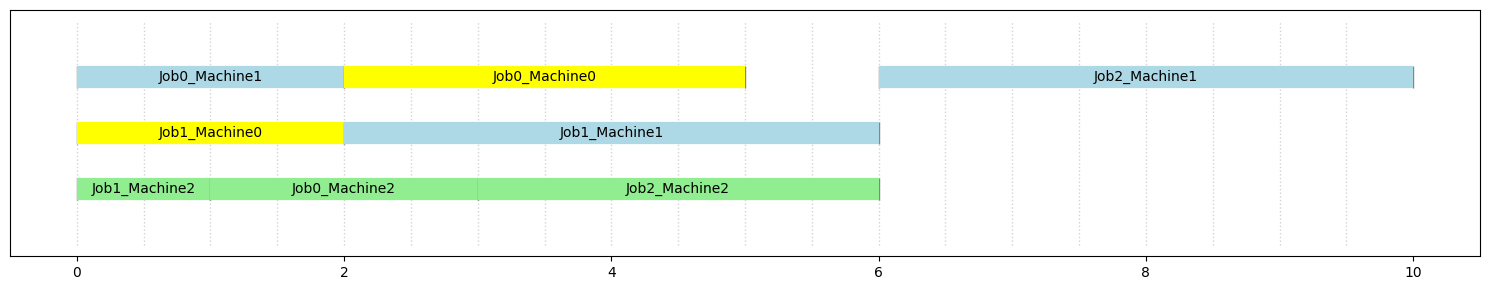

In [18]:
colors = ['yellow', 'lightblue', 'lightgreen']

for i in DV:
    var_sol = msol.get_var_solution(i)
    machine_id = int(i.name.split('_')[1].replace("Machine",''))
    #visu.panel()
    visu.interval(var_sol, colors[machine_id], i.name, )  
visu.show()

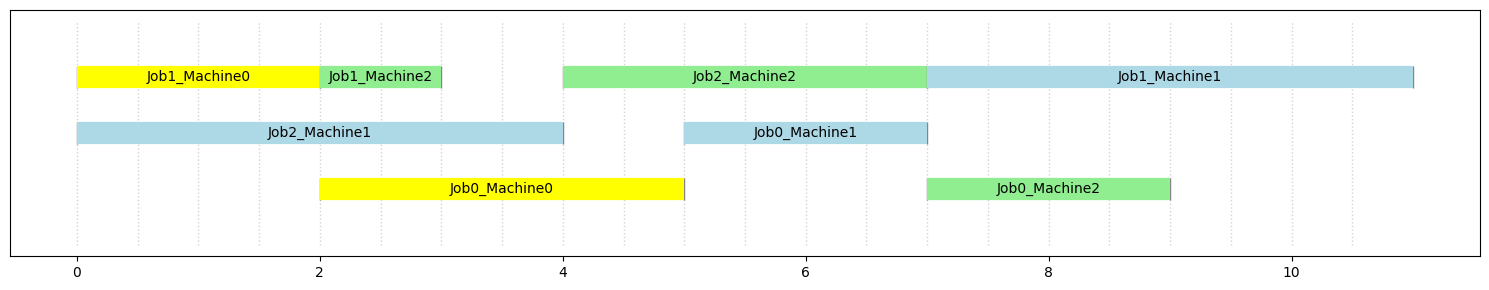

In [26]:
colors = ['yellow', 'lightblue', 'lightgreen']

for i in DV:
    var_sol = msol.get_var_solution(i)
    machine_id = int(i.name.split('_')[1].replace("Machine",''))
    #visu.panel()
    visu.interval(var_sol, colors[machine_id], i.name, )  
visu.show()

#pd.set_option('mode.chained_assignment', None)
# Find the latest task of each job
idx=  jobs_data.groupby(by='job')['order'].idxmax()
last_Tasks = jobs_data.loc[idx,]

last_Tasks['endtime'] = last_Tasks['DV'].apply(lambda x:mdl.end_of(x) )
last_Tasks


for i in all_machines:
    u= jobs_data[jobs_data['order']==2]
    u.loc[:,'endtime']=u['DV'].apply(lambda x:mdl.end_of(x))

obj = mdl.minimize ( mdl.max ( last_Tasks['endtime']) )
mdl.add(obj)

msol = mdl.solve(TimeLimit=50)

In [ ]:
"""Minimal jobshop example."""
import collections
from ortools.sat.python import cp_model


def main():
    """Minimal jobshop problem."""
    # Data.
    jobs_data = [  # task = (machine_id, processing_time).
        [(0, 3), (1, 2), (2, 2)],  # Job0
        [(0, 2), (2, 1), (1, 4)],  # Job1
        [(1, 4), (2, 3)]  # Job2
    ]

    machines_count = 1 + max(task[0] for job in jobs_data for task in job)
    all_machines = range(machines_count)
    # Computes horizon dynamically as the sum of all durations.
    horizon = sum(task[1] for job in jobs_data for task in job)

    # Create the model.
    model = cp_model.CpModel()

    # Named tuple to store information about created variables.
    task_type = collections.namedtuple('task_type', 'start end interval')
    # Named tuple to manipulate solution information.
    assigned_task_type = collections.namedtuple('assigned_task_type',
                                                'start job index duration')

    # Creates job intervals and add to the corresponding machine lists.
    all_tasks = {}
    machine_to_intervals = collections.defaultdict(list)

    for job_id, job in enumerate(jobs_data):
        for task_id, task in enumerate(job):
            machine = task[0]
            duration = task[1]
            suffix = '_%i_%i' % (job_id, task_id)
            start_var = model.NewIntVar(0, horizon, 'start' + suffix)
            end_var = model.NewIntVar(0, horizon, 'end' + suffix)
            interval_var = model.NewIntervalVar(start_var, duration, end_var,
                                                'interval' + suffix)
            all_tasks[job_id, task_id] = task_type(start=start_var,
                                                   end=end_var,
                                                   interval=interval_var)
            machine_to_intervals[machine].append(interval_var)

    # Create and add disjunctive constraints.
    for machine in all_machines:
        model.AddNoOverlap(machine_to_intervals[machine])

    # Precedences inside a job.
    for job_id, job in enumerate(jobs_data):
        for task_id in range(len(job) - 1):
            model.Add(all_tasks[job_id, task_id +
                                1].start >= all_tasks[job_id, task_id].end)

    # Makespan objective.
    obj_var = model.NewIntVar(0, horizon, 'makespan')
    model.AddMaxEquality(obj_var, [
        all_tasks[job_id, len(job) - 1].end
        for job_id, job in enumerate(jobs_data)
    ])
    model.Minimize(obj_var)

    # Creates the solver and solve.
    solver = cp_model.CpSolver()
    status = solver.Solve(model)

    if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
        print('Solution:')
        # Create one list of assigned tasks per machine.
        assigned_jobs = collections.defaultdict(list)
        for job_id, job in enumerate(jobs_data):
            for task_id, task in enumerate(job):
                machine = task[0]
                assigned_jobs[machine].append(
                    assigned_task_type(start=solver.Value(
                        all_tasks[job_id, task_id].start),
                                       job=job_id,
                                       index=task_id,
                                       duration=task[1]))

        # Create per machine output lines.
        output = ''
        for machine in all_machines:
            # Sort by starting time.
            assigned_jobs[machine].sort()
            sol_line_tasks = 'Machine ' + str(machine) + ': '
            sol_line = '           '

            for assigned_task in assigned_jobs[machine]:
                name = 'job_%i_task_%i' % (assigned_task.job,
                                           assigned_task.index)
                # Add spaces to output to align columns.
                sol_line_tasks += '%-15s' % name

                start = assigned_task.start
                duration = assigned_task.duration
                sol_tmp = '[%i,%i]' % (start, start + duration)
                # Add spaces to output to align columns.
                sol_line += '%-15s' % sol_tmp

            sol_line += '\n'
            sol_line_tasks += '\n'
            output += sol_line_tasks
            output += sol_line

        # Finally print the solution found.
        print(f'Optimal Schedule Length: {solver.ObjectiveValue()}')
        print(output)
    else:
        print('No solution found.')

    # Statistics.
    print('\nStatistics')
    print('  - conflicts: %i' % solver.NumConflicts())
    print('  - branches : %i' % solver.NumBranches())
    print('  - wall time: %f s' % solver.WallTime())


if __name__ == '__main__':
    main()